In [2]:
!git clone https://github.com/raoyongming/GFNet.git

fatal: destination path 'GFNet' already exists and is not an empty directory.


In [1]:
import pickle
import os
import sys
import numpy as np
import pandas as pd
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

In [2]:
!pip3 install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:

%cd image-classification
%pip install -r requirements.txt

import torch
torch.cuda.set_device(4)

/home/pekudrjavtseva/image-classification


UsageError: Line magic function `%pip` not found.


In [4]:
from tools.show import show_models

show_models()

Model Names    Model Variants
-------------  --------------------------------
ResNet         ['18', '34', '50', '101', '152']
MicroNet       ['M1', 'M2', 'M3']
GFNet          ['T', 'S', 'B']
PVTv2          ['B1', 'B2', 'B3', 'B4', 'B5']
ResT           ['S', 'B', 'L']
Conformer      ['T', 'S', 'B']
Shuffle        ['T', 'S', 'B']
CSWin          ['T', 'S', 'B', 'L']
CycleMLP       ['B1', 'B2', 'B3', 'B4', 'B5']
XciT           ['T', 'S', 'M', 'L']
VOLO           ['D1', 'D2', 'D3', 'D4']


In [5]:
from models import get_model
import torch

model = get_model('CSWin', 'B', pretrained='/home/pekudrjavtseva/checkpoints/CSWin/cswin_base_224.pth')
image = torch.randn(1, 3, 224, 224)
output = model(image)
output.shape

torch.Size([1, 1000])

In [6]:
def create_labels(label_path):
  l = pd.read_csv(label_path, sep = ',')
  p = pd.DataFrame()
  p['id'] = l.iloc[:, 0] + '.jpg'
  p['breed'] = l.iloc[:, 1]

  d = {}
  for i in range(0, p.shape[0]):
    d[p.iloc[i, 0]] = p.iloc[i, 1]

  return d

class DogsDataset(Dataset):
   def __init__(self, files, mode, label_path = '/content/dogs/labels.csv', transform=None):
     super().__init__()
     # список файлов для загрузки
     self.files = sorted(files)
     self.labels_dict = create_labels(label_path)

     DATA_MODES = ['train', 'val', 'test']
     # режим работы
     self.mode = mode
     if self.mode not in DATA_MODES:
       print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
       raise NameError
     self.len_ = len(self.files)

     self.label_encoder = LabelEncoder()
     if self.mode != 'test':
       self.labels = [self.labels_dict[path.name] for path in self.files]
       #self.labels = [path.parent.name for path in self.files]
       self.label_encoder.fit(self.labels)
       with open('label_encoder.pkl', 'wb') as le_dump_file:
         pickle.dump(self.label_encoder, le_dump_file)

     if (transform == None):
       self.transform_train = transforms.Compose([transforms.ToTensor(), 
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
     else:

       self.transform_train = transform

   def __len__(self):
       return self.len_

   def load_sample(self, file):
       image = Image.open(file)
       image.load()
       return image
   def _prepare_sample(self, image):
     image = image.resize((224, 224))
     return np.array(image)

   def __getitem__(self, index):

     transform_train = self.transform_train
    
     transform_test = transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
     x = self.load_sample(self.files[index])
     x = self._prepare_sample(x)
     x = np.array(x / 255, dtype='float32')
     if self.mode == 'test':
         return transform_test(x) #тестовую не меняем
     else:
         if self.mode == 'train':
           x= transform_train(x)
         else:
           x=transform_test(x)
         label = self.labels[index]
         label_id = self.label_encoder.transform([label])
         y = label_id.item()
         return x, y



def imshow(inp, title=None, plt_ax=plt, default=False):
 inp = inp.numpy().transpose((1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 inp = std * inp + mean
 inp = np.clip(inp, 0, 1)
 plt_ax.imshow(inp)
 if title is not None:
   plt_ax.set_title(title)
 plt_ax.grid(False)


def fit_epoch(model, train_loader, criterion, optimizer, device = torch.device("cuda")):

  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc


def eval_epoch(model, val_loader, criterion, device = torch.device("cuda")):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc

def train(train_dataset, val_dataset, model, opt, epochs, batch_size, name):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  history = []
  final_acc = 0
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    #opt = torch.optim.AdamW(model.parameters(), lr=0.00005, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      if val_acc > final_acc:
        torch.save({'model_state_dict': model.state_dict(),}, name)
        final_acc = val_acc
        print("Saved model with val acc", val_acc.item())
      history.append((train_loss, train_acc.item(), val_loss, val_acc.item()))
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

  return history

def predict(model, test_loader, device = torch.device("cuda")):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(device)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def plot(history, name):

  loss, acc, val_loss, val_acc = zip(*history)
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.title(name)
  plt.show()

def make_prediction(name, model, test_files):
  
  checkpoint = torch.load(name)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()

  test_dataset = DogsDataset(test_files, mode='test')
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

  probs = predict(model, test_loader)
  label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

  result = pd.DataFrame(columns = label_encoder.inverse_transform(np.arange(0, 120)))

  result['id'] = [path.name.split('.')[0] for path in test_files]

  for i in range(len(test_files)):
    result.iloc[i, :-1] = probs[i]
    
  return result



def initialize_and_train_model(model_name, output_num, epochs, batch_size, train_dataset, val_dataset, save_name):
  models_list = ["ResNet152", "VGG19", "DenseNet161", "EfficientNet"]

  if model_name not in models_list:
       print(f"{model_name} is not correct; correct modes: {models_list}")
       raise NameError

  if (model_name == "ResNet152"):
    model = models.resnet152(pretrained=True)

    model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
                             nn.Dropout(0.5),
                             nn.Linear(1000, 120, bias=True))
  elif (model_name == "VGG19"):
    model = models.vgg19(pretrained = True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=120, bias=True)

  elif (model_name == "DenseNet161"):
    model = models.densenet161(pretrained=True)

    model.classifier = nn.Sequential(nn.Linear(2208, 128),
                              nn.BatchNorm1d(128),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(128, 120))
  
  else:
    model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=120)

  torch.cuda.empty_cache()
  opt = torch.optim.AdamW(model.parameters(), lr=0.00005, amsgrad=True)
  history = train(train_dataset, val_dataset, model.cuda(), opt, epochs, batch_size, save_name)
  plot(history, model_name)
  return model

In [7]:
!ls /home/pekudrjavtseva/dogs

labels.csv  sample_submission.csv  test  train


In [8]:
d = create_labels('/home/pekudrjavtseva/dogs/labels.csv')

In [9]:
TRAIN_DIR = Path('/home/pekudrjavtseva/dogs/train')
TEST_DIR = Path('/home/pekudrjavtseva/dogs/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [d[path.name] for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

train_dataset = DogsDataset(train_files, mode='train', label_path = '/home/pekudrjavtseva/dogs/labels.csv')

val_dataset = DogsDataset(val_files, mode='val', label_path = '/home/pekudrjavtseva/dogs/labels.csv')

test_dataset = DogsDataset(test_files, mode='test', label_path = '/home/pekudrjavtseva/dogs/labels.csv')

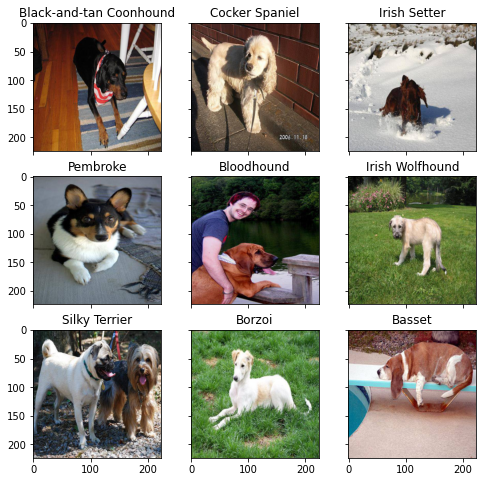

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,1000))
 im_val, label = train_dataset[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [11]:
DEVICE = torch.device("cuda")

In [13]:
torch.cuda.empty_cache()
name = 'cswin.pth'
torch.cuda.set_device(4)

opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset, val_dataset, model= model.cuda(), opt = opt, epochs=50, batch_size=8, name = name)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 5.144287704395122


epoch:   2%|▏         | 1/50 [1:15:28<61:38:02, 4528.20s/it]

Saved model with val acc 0.01134585289514867

Epoch 001 train_loss: 5.1443   val_loss 4.8267 train_acc 0.0077 val_acc 0.0113
loss 4.819679014682148


epoch:   4%|▍         | 2/50 [2:27:24<59:31:47, 4464.74s/it]

Saved model with val acc 0.012519561815336464

Epoch 002 train_loss: 4.8197   val_loss 4.7966 train_acc 0.0086 val_acc 0.0125
loss 4.806143009783921


epoch:   6%|▌         | 3/50 [3:35:44<56:51:33, 4355.17s/it]


Epoch 003 train_loss: 4.8061   val_loss 4.7933 train_acc 0.0106 val_acc 0.0113
loss 4.804401505064971


epoch:   8%|▊         | 4/50 [4:45:34<55:00:59, 4305.65s/it]


Epoch 004 train_loss: 4.8044   val_loss 4.7882 train_acc 0.0102 val_acc 0.0110


epoch:   8%|▊         | 4/50 [5:12:39<59:55:35, 4689.90s/it]


KeyboardInterrupt: 

In [24]:
next(model.parameters()).is_cuda

True

In [ ]:
import timm
model = timm.create_model('efficientnet_b1_pruned', pretrained=True, num_classes=120)

torch.cuda.empty_cache()
name = 'efficientnet_b1_pruned'
torch.cuda.set_device(4)

opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset, val_dataset, model= model.cuda(), opt = opt, epochs=50, batch_size=8, name = name)

Downloading: "https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45403/outputs/effnetb1_pruned_9ebb3fe6.pth" to /home/pekudrjavtseva/.cache/torch/hub/checkpoints/effnetb1_pruned_9ebb3fe6.pth
epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.753988175550143


epoch:   2%|▏         | 1/50 [1:00:57<49:46:49, 3657.33s/it]

Saved model with val acc 0.656885758998435

Epoch 001 train_loss: 2.7540   val_loss 1.1844 train_acc 0.3714 val_acc 0.6569
loss 0.7747657615258928


epoch:   4%|▍         | 2/50 [2:01:52<48:45:20, 3656.68s/it]

Saved model with val acc 0.7171361502347418

Epoch 002 train_loss: 0.7748   val_loss 0.9619 train_acc 0.7726 val_acc 0.7171
loss 0.3712526388901769


epoch:   6%|▌         | 3/50 [3:02:55<47:45:51, 3658.55s/it]


Epoch 003 train_loss: 0.3713   val_loss 1.0042 train_acc 0.8827 val_acc 0.7093
loss 0.15568130376571127


epoch:   8%|▊         | 4/50 [4:03:53<46:44:51, 3658.52s/it]


Epoch 004 train_loss: 0.1557   val_loss 1.0762 train_acc 0.9536 val_acc 0.7160
loss 0.0656121212847802


epoch:  10%|█         | 5/50 [5:04:57<45:44:55, 3659.90s/it]


Epoch 005 train_loss: 0.0656   val_loss 1.2069 train_acc 0.9845 val_acc 0.7085
loss 0.033580394423755794


epoch:  12%|█▏        | 6/50 [6:06:06<44:45:57, 3662.67s/it]

Saved model with val acc 0.727699530516432

Epoch 006 train_loss: 0.0336   val_loss 1.2091 train_acc 0.9930 val_acc 0.7277
loss 0.018315773872563123


epoch:  14%|█▍        | 7/50 [7:07:16<43:46:36, 3665.03s/it]


Epoch 007 train_loss: 0.0183   val_loss 1.2975 train_acc 0.9973 val_acc 0.7218
loss 0.010779228041992026


epoch:  16%|█▌        | 8/50 [8:08:38<42:49:00, 3670.01s/it]


Epoch 008 train_loss: 0.0108   val_loss 1.3911 train_acc 0.9982 val_acc 0.7222
loss 0.007988336101467777


epoch:  18%|█▊        | 9/50 [9:09:38<41:45:49, 3667.06s/it]


Epoch 009 train_loss: 0.0080   val_loss 1.3894 train_acc 0.9983 val_acc 0.7277
